# Solutions 1 - Examples in Julia

---

## Assignment 1

The function `eps()` return the smallest real number larger than 1.0. It can be called for each of the `AbstractFloat` types. 

Functions `realmin()` and `realmax()` return the largest and the smallest positive numbers representable in the given type.

In [3]:
?eps()

```
eps()
```

The distance between 1.0 and the next larger representable floating-point value of `Float64`.


In [4]:
?realmax()

```
realmax(T)
```

The highest finite value representable by the given floating-point DataType `T`.


In [5]:
subtypes(AbstractFloat)

4-element Array{Any,1}:
 BigFloat
 Float16 
 Float32 
 Float64 

In [6]:
# Default values are for Float66
eps(), realmax(), realmin()

(2.220446049250313e-16,1.7976931348623157e308,2.2250738585072014e-308)

In [11]:
T=Float16
eps(T), realmax(T), realmin(T)

(Float16(0.000977),Float16(6.55e4),Float16(6.104e-5))

In [9]:
2.0^(-23)

1.1920928955078125e-7

In [12]:
T=BigFloat
eps(T), realmax(T), realmin(T), map(Int64,round(log10(1/eps(T))*log(10)/log(2)))

(1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77,2.09857871646738769240435811688383907063809796547335262778664622571024044777575e+323228496,2.382564904887951073216169781732674520415196125559239787955023752600945386104324e-323228497,255)

We see that `BigFloat` has approximately 77 significant decimal digits (actually 256 bits) and very large exponents. This makes the format ideal for Greaffe's method. 

Precision of `BigFloat` can be increased, but exponents do not change.

In [13]:
get_bigfloat_precision()

256

In [14]:
set_bigfloat_precision(512)
eps(T), realmax(T)

(1.49166814624004134865819306309258676747529430692008137885430366664125567701402366098723497808008556067230232065116722029068254561904506053209723296591841694e-154,2.09857871646738769240435811688383907063809796547335262778664622571024044777576820818355304081267655987295599577960564840596747121502665142009783113610500033e+323228496)

In [15]:
set_bigfloat_precision(256)

256

Here is the function for Graeffe's method. We also define small test polynomial with all real simple zeros.

In [18]:
using Polynomials
p=poly([1,2,3,4])

Poly(24 - 50x + 35x^2 - 10x^3 + x^4)

In [19]:
roots(p)

4-element Array{Float64,1}:
 1.0
 2.0
 3.0
 4.0

In [20]:
function Graeffe{T}(p::Poly{T},steps::Int64)
    # map the polynomial to BigFloat
    pbig=Poly(map(BigFloat,coeffs(p)))
    px=Poly([zero(BigFloat),one(BigFloat)])
    n=degree(p)
    σ=map(BigFloat,2^steps)
    for k=1:steps
        peven=Poly(coeffs(pbig)[1:2:end])
        podd=Poly(coeffs(pbig)[2:2:end])
        pbig=peven^2-podd^2*px 
    end
    # @show p[end]
    y=Array(BigFloat,n)
    # Normalize if p is not monic
    y[1]=-pbig[end-1]/pbig[end]
    for k=2:n
        y[k]=-pbig[end-k]/pbig[end-(k-1)]
    end
    # Extract the roots
    for k=1:n
        y[k]=exp(log(y[k])/σ)
    end
    # Return root in Float64
    map(Float64,y)
end

Graeffe (generic function with 1 method)

In [21]:
Graeffe(p,8)

4-element Array{Float64,1}:
 4.0
 3.0
 2.0
 1.0

Now the Wilkinson's polynomial:

In [22]:
ω=poly(collect(one(BigFloat):20))

Poly(2.432902008176640000000000000000000000000000000000000000000000000000000000000000e+18 - 8.752948036761600000000000000000000000000000000000000000000000000000000000000000e+18x + 1.380375975364070400000000000000000000000000000000000000000000000000000000000000e+19x^2 - 1.287093124515098880000000000000000000000000000000000000000000000000000000000000e+19x^3 + 8.037811822645051776000000000000000000000000000000000000000000000000000000000000e+18x^4 - 3.599979517947607200000000000000000000000000000000000000000000000000000000000000e+18x^5 + 1.206647803780373360000000000000000000000000000000000000000000000000000000000000e+18x^6 - 3.113336431613906400000000000000000000000000000000000000000000000000000000000000e+17x^7 + 6.303081209929489600000000000000000000000000000000000000000000000000000000000000e+16x^8 - 1.014229986551145000000000000000000000000000000000000000000000000000000000000000e+16x^9 + 1.307535010540395000000000000000000000000000000000000000000000000000000000000000e+15x^10 - 1.3558518

In [27]:
Graeffe(ω,12)-collect(20:-1:1)

20-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

We need to generate the Chebyshev polynomial $T_{50}(x)$ using the three term recurence. 

In [28]:
n=50
T0=Poly([BigInt(1)])
T1=Poly([0,1])
Tx=Poly([0,1])
for i=3:n+1
    T=2*Tx*T1-T0
    T0=T1
    T1=T
end

In [29]:
T1

Poly(-1 + 1250x^2 - 260000x^4 + 21528000x^6 - 947232000x^8 + 25638412800x^10 - 466152960000x^12 + 6034375680000x^14 - 57930006528000x^16 + 424820047872000x^18 - 2432653747814400x^20 + 11057517035520000x^22 - 40383975260160000x^24 + 119536566770073600x^26 - 288405684905574400x^28 + 568855350917201920x^30 - 917508630511616000x^32 + 1206989963132928000x^34 - 1287455960675123200x^36 + 1102487181118668800x^38 - 746299014911098880x^40 + 390051749953536000x^42 - 151732604633088000x^44 + 41341637204377600x^46 - 7036874417766400x^48 + 562949953421312x^50)

In [30]:
using Winston

In [31]:
x=linspace(-1,1,300)

linspace(-1.0,1.0,300)

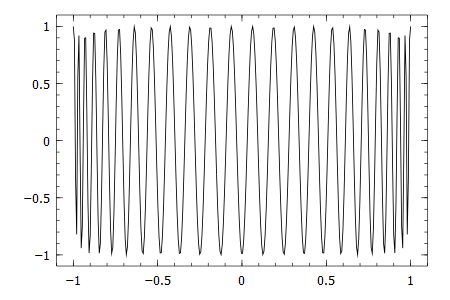

In [32]:
plot(x,T1(x))

In order to use Graeffe's method, we need to shift $T$ to the right by one, so that all roots also have simple moduli, that is we compute $T(1-x)$:

In [33]:
Ts=T1(Poly([BigFloat(1),-1]));

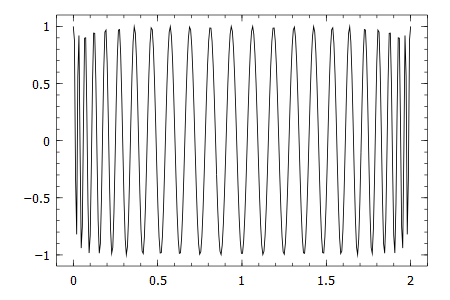

In [34]:
xs=linspace(0,2,300)
plot(xs, Ts(xs))

In [38]:
# Computed roots, 16 steps are fine
y=Graeffe(Ts,16)-1

50-element Array{Float64,1}:
  0.999507
  0.995562
  0.987688
  0.975917
  0.960294
  0.940881
  0.917755
  0.891007
  0.860742
  0.827081
  0.790155
  0.750111
  0.707107
  ⋮       
 -0.750111
 -0.790155
 -0.827081
 -0.860742
 -0.891007
 -0.917755
 -0.940881
 -0.960294
 -0.975917
 -0.987688
 -0.995562
 -0.999507

In [39]:
# Exact roots
z=map(Float64,[cos((2*k-1)*pi/(2*n)) for k=1:n])

50-element Array{Float64,1}:
  0.999507
  0.995562
  0.987688
  0.975917
  0.960294
  0.940881
  0.917755
  0.891007
  0.860742
  0.827081
  0.790155
  0.750111
  0.707107
  ⋮       
 -0.750111
 -0.790155
 -0.827081
 -0.860742
 -0.891007
 -0.917755
 -0.940881
 -0.960294
 -0.975917
 -0.987688
 -0.995562
 -0.999507

In [40]:
# Relative error
maximum(abs(z-y)./z)

3.313622835402366e-15

## Assignment 2

The key is that `/` works for block matrices, too. $A$ is overwritten and must therefore be copied at the beggining of the function, so that the original matrix is not overwritten.

In [43]:
function mylu{T}(A1::Array{T}) # Strang, page 100
    A=copy(A1)
    n,m=size(A)
    for k=1:n-1
        for rho=k+1:n
            A[rho,k]=A[rho,k]/A[k,k]
            for l=k+1:n
                A[rho,l]=A[rho,l]-A[rho,k]*A[k,l]
            end
        end
    end
    # We return L and U
    L=tril(A,-1)
    U=triu(A)
    # This is the only difference for the block case
    for i=1:maximum(size(L))
        L[i,i]=one(L[1,1])
    end
    L,U
end

mylu (generic function with 1 method)

In [41]:
A=rand(5,5)

5x5 Array{Float64,2}:
 0.909439  0.240272   0.17257   0.802504   0.228327
 0.126405  0.314816   0.7885    0.119634   0.444086
 0.140211  0.868449   0.837537  0.58373    0.663519
 0.108679  0.0976644  0.51691   0.807496   0.939983
 0.149304  0.425137   0.974446  0.0949694  0.213306

In [44]:
mylu(A)

(
5x5 Array{Float64,2}:
 1.0       0.0        0.0         0.0        0.0
 0.138992  1.0        0.0         0.0        0.0
 0.154173  2.95433    1.0         0.0        0.0
 0.119501  0.245014  -0.213423    1.0        0.0
 0.164171  1.37052    0.0702252  -0.0977892  1.0,

5x5 Array{Float64,2}:
 0.909439  0.240272   0.17257   0.802504     0.228327
 0.0       0.28142    0.764514  0.00809211   0.41235 
 0.0       0.0       -1.44769   0.436099    -0.589901
 0.0       0.0        0.0       0.802687     0.685768
 0.0       0.0        0.0       0.0         -0.280826)

In [46]:
L,U=mylu(A)

(
5x5 Array{Float64,2}:
 1.0       0.0        0.0         0.0        0.0
 0.138992  1.0        0.0         0.0        0.0
 0.154173  2.95433    1.0         0.0        0.0
 0.119501  0.245014  -0.213423    1.0        0.0
 0.164171  1.37052    0.0702252  -0.0977892  1.0,

5x5 Array{Float64,2}:
 0.909439  0.240272   0.17257   0.802504     0.228327
 0.0       0.28142    0.764514  0.00809211   0.41235 
 0.0       0.0       -1.44769   0.436099    -0.589901
 0.0       0.0        0.0       0.802687     0.685768
 0.0       0.0        0.0       0.0         -0.280826)

In [47]:
L*U-A

5x5 Array{Float64,2}:
 0.0   0.0          0.0           0.0           0.0        
 0.0   0.0          0.0           0.0           0.0        
 0.0   0.0          2.22045e-16   0.0           0.0        
 0.0   1.38778e-17  0.0          -1.11022e-16   0.0        
 0.0  -5.55112e-17  0.0          -1.38778e-17  -5.55112e-17

We now try block-matrices. First, a small example:

In [48]:
# Try k,l=32,16 i k,l=64,8
k,l=2,4
Ab=[rand(k,k) for i=1:l, j=1:l]

4x4 Array{Any,2}:
 2x2 Array{Float64,2}:
 0.845638  0.911772
 0.907423  0.261845    …  2x2 Array{Float64,2}:
 0.389727  0.739806
 0.385009  0.201487
 2x2 Array{Float64,2}:
 0.227364   0.656247
 0.0369204  0.692578     2x2 Array{Float64,2}:
 0.140008  0.336937
 0.694196  0.190428
 2x2 Array{Float64,2}:
 0.450417  0.934377
 0.743459  0.206934       2x2 Array{Float64,2}:
 0.121656  0.273178
 0.588559  0.474825
 2x2 Array{Float64,2}:
 0.396269  0.961155
 0.910587  0.773658       2x2 Array{Float64,2}:
 0.217633  0.869163
 0.193132  0.753646

In [49]:
Ab[1,1]

2x2 Array{Float64,2}:
 0.845638  0.911772
 0.907423  0.261845

In [50]:
L,U=mylu(Ab)

(
4x4 Array{Any,2}:
 2x2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0                            …  2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0
 2x2 Array{Float64,2}:
 0.884514  -0.573729
 1.02122   -0.910998         2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0
 2x2 Array{Float64,2}:
  1.20464    -0.626249
 -0.0113775   0.829911     2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0
 2x2 Array{Float64,2}:
 1.26814   -0.745098
 0.765101   0.29048          2x2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0,

4x4 Array{Any,2}:
 2x2 Array{Float64,2}:
 0.845638  0.911772
 0.907423  0.261845  …  2x2 Array{Float64,2}:
 0.389727  0.739806
 0.385009  0.201487    
 2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0                         2x2 Array{Float64,2}:
 0.0161797  -0.201833
 0.646942   -0.381521
 2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0                         2x2 Array{Float64,2}:
  1.92828  -1.63467
 -1.84915   1.41842    
 2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0                         2x2 Array{Float64,2}:
 9.55773  -7

In [51]:
L*U-Ab

4x4 Array{Any,2}:
 2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0                                      …  2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0                  
 2x2 Array{Float64,2}:
 -1.11022e-16  -2.22045e-16
  1.11022e-16   0.0             2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0                  
 2x2 Array{Float64,2}:
 1.11022e-16  1.11022e-16
 0.0          0.0                 2x2 Array{Float64,2}:
 0.0  -2.22045e-16
 0.0   0.0        
 2x2 Array{Float64,2}:
 1.11022e-16   0.0        
 0.0          -1.11022e-16       2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0                  

In [52]:
norm(ans) # This is not defined

LoadError: LoadError: MethodError: `zero` has no method matching zero(::Type{Any})
while loading In[52], in expression starting on line 1

We need a convenience function to unblock the block-matrix:

In [53]:
unblock(A) = mapreduce(identity, hcat, [mapreduce(identity, vcat, A[:,i]) for i = 1:size(A,2)])

unblock (generic function with 1 method)

In [54]:
unblock(Ab)

8x8 Array{Float64,2}:
 0.845638   0.911772  0.798847   0.72073    …  0.279218   0.389727  0.739806
 0.907423   0.261845  0.0818986  0.101509      0.0603307  0.385009  0.201487
 0.227364   0.656247  0.0409198  0.864467      0.799845   0.140008  0.336937
 0.0369204  0.692578  0.691294   0.914854      0.133188   0.694196  0.190428
 0.450417   0.934377  0.884088   0.0341631     0.803797   0.121656  0.273178
 0.743459   0.206934  0.374808   0.749917   …  0.0705468  0.588559  0.474825
 0.396269   0.961155  0.196948   0.707987      0.694111   0.217633  0.869163
 0.910587   0.773658  0.743805   0.189951      0.206279   0.193132  0.753646

In [55]:
norm(unblock(L*U-Ab))

3.437000757272753e-16

We now compute timings and errors for bigger example:

In [56]:
# This is 512x512 matrix consisting of 16x16 blocks of dimension 32x32
k,l=32,16
Ab=[rand(k,k) for i=1:l, j=1:l]
# Unblocked version
A=unblock(Ab);

In [58]:
?lu

search: lu lufact lufact! flush flush_cstdio ClusterManager mylu values include



```
lu(A) -> L, U, p
```

Compute the LU factorization of `A`, such that `A[p,:] = L*U`.


In [61]:
# Built-in LAPACK function with pivoting 
@time L,U,p=lu(A);

  0.103706 seconds (41 allocations: 6.009 MB)


In [62]:
norm(L*U-A[p,:])

5.4481090742931926e-14

In [64]:
# mylu() unblocked
@time L,U=mylu(A);

  0.464659 seconds (13 allocations: 6.000 MB)


In [65]:
norm(L*U-A)

3.861239549848702e-12

In [67]:
# mylu() on a block-matrix - much faster, but NO pivoting
@time L,U=mylu(Ab);

  0.145258 seconds (7.04 k allocations: 26.606 MB, 2.37% gc time)


In [68]:
norm(unblock(L*U-Ab))

2.911078328049055e-12

## Assignment 3

In [70]:
k=20
n=20
E=Array(Complex,n,k)
# Unsymmetrix random uniform distribution
for i=1:k
    A=rand(n,n)
    E[:,i]=eigvals(A)
end
# We need this since plot cannot handle `Any`
E=map(eltype(E[1,1]),E)

20x20 Array{Complex{Float64},2}:
   10.1523+0.0im         9.73782+0.0im       …     10.1887+0.0im     
  0.862289+1.1588im    -0.374537+1.37831im        0.558517+1.05532im 
  0.862289-1.1588im    -0.374537-1.37831im        0.558517-1.05532im 
   1.38692+0.0im        0.998762+0.227093im        1.03652+0.0im     
    1.1609+0.0im        0.998762-0.227093im       0.846287+0.388706im
  -1.37876+0.426577im  0.0329614+1.13948im   …    0.846287-0.388706im
  -1.37876-0.426577im  0.0329614-1.13948im        0.788926+0.0im     
  0.411231+0.968689im   0.350605+0.70573im        0.498748+0.633448im
  0.411231-0.968689im   0.350605-0.70573im        0.498748-0.633448im
  0.589964+0.277101im   0.453071+0.297922im      0.0949016+1.02449im 
  0.589964-0.277101im   0.453071-0.297922im  …   0.0949016-1.02449im 
 -0.812268+0.647258im  -0.823269+0.467572im        -0.6946+0.812845im
 -0.812268-0.647258im  -0.823269-0.467572im        -0.6946-0.812845im
 -0.149166+0.668645im  -0.434661+0.735489im       -1.0607

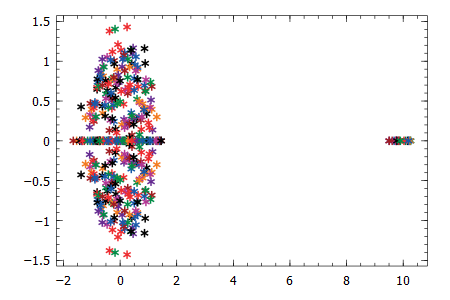

In [71]:
Winston.plot(E,"*")

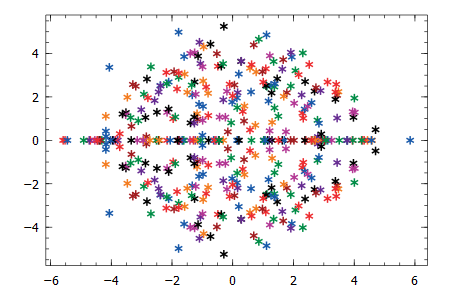

In [72]:
# Unsymmetric random normal distribution
E=Array(Any,n,k)
for i=1:k
    A=randn(n,n)
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

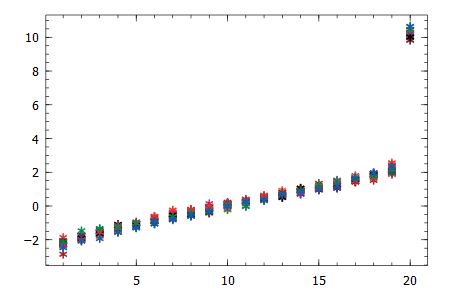

In [74]:
# Symmetric random uniform distribution
E=Array(Any,n,k)
for i=1:k
    A=rand(n,n)
    A=triu(A)+triu(A,1)'
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

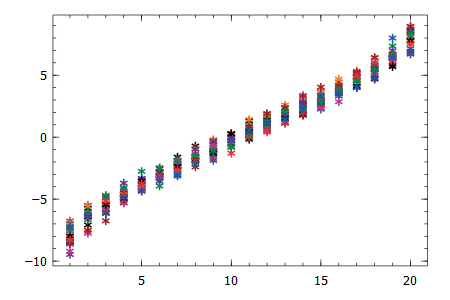

In [75]:
# Symmetric random normal distribution
E=Array(Any,n,k)
for i=1:k
    A=randn(n,n)
    A=triu(A)+triu(A,1)'
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

Interact.Slider{Int64}(Signal{Int64}(20, nactions=0),"k",20,10:30,true)

Interact.Slider{Int64}(Signal{Int64}(20, nactions=0),"n",20,10:30,true)

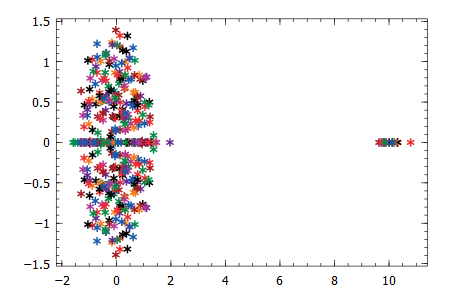

In [79]:
# Now the interactive part
using Interact
@manipulate for k=10:30, n=10:30
    E=Array(Any,n,k)
    for i=1:k
        A=rand(n,n)
        # A=triu(A)+triu(A,1)'
        E[:,i]=eigvals(A)
    end
    # We need this for plot to work
    E=map(eltype(E[1,1]),E)
    Winston.plot(E,"*")
end

_Mathematics is about spotting patterns_ (Alan Edelman)